In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
experiment = "e"

In [3]:
filepath = os.path.join("input_data", experiment+".txt")
f = open(filepath)

In [4]:
first_line = f.readline()
vals = first_line.split(" ")
D = int(vals[0])
I = int(vals[1])
S = int(vals[2])
V = int(vals[3])
F = int(vals[4])
print("D={}, I={}, S={}, V={}, F={}".format(D,I,S,V,F))

D=676, I=500, S=998, V=1000, F=500


In [5]:
# Create mapping streetname to id {"streetname": id}
mapping_streetnames = {}
inverse_mapping = []
outgoing_streets = {}
incoming_streets = {}
street_connectors = {}
street_durations = {}

i = 0;
while i < S:
    l = f.readline()
    vals = l.split(" ")
    B = int(vals[0])     # intersection beginning of the street
    E = int(vals[1])     # intersection end of the street
    name = vals[2]       # street name
    L = int(vals [3]) 
    mapping_streetnames[name] = i
    inverse_mapping.append(name)
    
    try:
        streets = outgoing_streets[B]
        streets.append(name)
        outgoing_streets[B] = streets
    except:
        # key Error
        outgoing_streets[B] = [name]
    
    try:
        streets = incoming_streets[E]
        streets.append(name)
        incoming_streets[E] = streets
    except:
        # key Error
        incoming_streets[E] = [name]
    
    street_connectors[name] = {"B": B, "E": E}
    street_durations[name] = L
    i += 1
 
#print(outgoing_streets)
#print(incoming_streets)



In [6]:
#print(mapping_streetnames)
#print(inverse_mapping)

In [7]:
# Create ranking how many times a street is part of a path.
ranking = np.zeros(S)

for j in range(V):
    l = f.readline()
    vals = l.split("\n")[0].split(" ")
    for i in range(1,int(vals[0])): # do not consider last street because last intersection isn't travelled through
        street_on_path = vals[i]
        ranking[mapping_streetnames[street_on_path]] += 1
        
    

In [8]:
#print(ranking)

In [9]:
threshold = np.median(ranking)
print("min:{}".format(np.min(ranking)))
print("max:{}".format(np.max(ranking)))
print("threshold: {}".format(threshold))

min:0.0
max:20.0
threshold: 4.0


In [10]:
common_streets = []
for i in range(len(ranking)):
    if ranking[i] > threshold:
        common_streets.append(inverse_mapping[i])
#print(common_streets)
        
    

In [11]:
def give_following_street(streetname):
    
    intersection_end = street_connectors[streetname]["E"]
    
    return outgoing_streets[intersection_end]
    
def give_previous_street(streetname):
    
    intersection_begining = street_connectors[streetname]["B"]
    
    return incoming_streets[intersection_begining]

In [12]:
def recursive_next_street(current_street):
    following_streets = give_following_street(current_street)
    for fs in following_streets:
        if fs in common_streets:
            # todo: take the street with the highest ranking instead of the first one
            common_forward_path.append(fs)
            common_streets.remove(fs)
            recursive_next_street(fs)
            break
    return 

In [13]:
def recursive_previous_street(current_street):
    previous_streets = give_previous_street(current_street)
    for ps in previous_streets:
        if ps in common_streets:
            # todo
            common_backwards_path.append(ps)
            common_streets.remove(ps)
            recursive_previous_street(ps)
            break
    return

In [14]:
common_paths = [] #[["a","b","c"], ["d","e"]]

while len(common_streets) > 0:
    
    # forward
    street = common_streets[0]
    common_forward_path = [street]
    common_streets.remove(street)
    recursive_next_street(street)
    
    # backward
    common_backwards_path = []
    recursive_previous_street(street)

    # merge them
    if(len(common_forward_path) == 1 and len(common_backwards_path) == 0):
        continue
    
    new_path = []
    for subpath in reversed(common_backwards_path):
        new_path.append(subpath)
    
    
    new_path += common_forward_path
    
    common_paths.append(new_path)

  

In [15]:
#print(common_paths) 

(array([11.,  9.,  2.,  5.,  3.,  7.,  2.,  2.,  0.,  1.]),
 array([ 2. ,  4.9,  7.8, 10.7, 13.6, 16.5, 19.4, 22.3, 25.2, 28.1, 31. ]),
 <BarContainer object of 10 artists>)

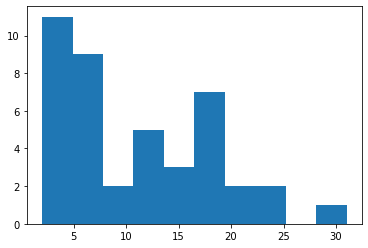

In [16]:
lengths = []
for p in common_paths: 
    lengths.append(len(p))

plt.figure()
plt.hist(lengths)

In [17]:
def sort_longest_paths(paths):
    sorted_path = sorted(paths, key=len, reverse=True)
    return sorted_path

sorted_common_paths = sort_longest_paths(common_paths)
print(len(sorted_common_paths[0]))
print(len(sorted_common_paths[-1]))

31
2


In [18]:

#schedule = [
#  [{"is_1":0}, {"is_2":0}], #Intersection 0  TUUUPLES!!
#  [{"is_1":0}, {"is_2":0}], #Intersection 1
#]

schedule = []
statistics_num_inc_streets = []
for intersection_id in range(I):
    is_schedule = []
    
    #todo: limit to the incoming streets where there is traffic
    ##print(incoming_streets[intersection_id])
    ##print(len(incoming_streets[intersection_id]))
    for p in incoming_streets[intersection_id]:
        is_schedule.append([ p, 0 ] )
    statistics_num_inc_streets.append(len(incoming_streets[intersection_id]))
    schedule.append(is_schedule)  
    

In [19]:
#print(statistics_num_inc_streets)

In [20]:
count_can_optimize = 0
count_need_extra_delay = 0

for current_path in sorted_common_paths:
    
    #at T = 0, the car is at the end of the begining of the first street of the common path
    #current_path = sorted_common_paths[0]

    T = 0
    t_accumulated = 0

    debug_list_mod_int = []

    for street in current_path:
        t_accumulated += street_durations[street]

        next_intersection_id = street_connectors[street]["E"]
        debug_list_mod_int.append(next_intersection_id)

        int_schedule = schedule[next_intersection_id]

        #calculate desired position
        desired_position = t_accumulated % len(int_schedule) # assuming schedule will only have one's

        # try optimize schedule 
        considered_inc_street = street


        current_position = None
        for index_d, val in enumerate(int_schedule):
            if val[0]==considered_inc_street:
                current_position = index_d
                break

        optimization_possible = (int_schedule[desired_position][1] == 0)

        extra_delay = 0

        if optimization_possible:
            ##print("We can optimize")
            ##print("original schedule: ", int_schedule)
            # swap the tuple corresponding to the desired incoming street with the non optimal tuple with Ti=0

            count_can_optimize += 1
            
            tmp_desired = [considered_inc_street, 1]    
            tmp_swaped = int_schedule[desired_position]
            int_schedule[current_position] = tmp_swaped
            int_schedule[desired_position] = tmp_desired

            #[{"is_1":0}, {"is_2":0}, {"is_3":0},{"is_3":0}]
        else:
            ##print("We cannot optimize")
            # calculate extra delay
            count_need_extra_delay += 1 
            extra_delay = abs(current_position - desired_position)
            #print("extra_delay: ", extra_delay)

        t_accumulated += extra_delay

print("#can optimize: ", count_can_optimize)
print("#need extra delay: ", count_need_extra_delay)

#can optimize:  441
#need extra delay:  4


In [21]:
for s in schedule:
    for e in s:
        if e[-1] != 0:
            print(s, "\n")

[['eji-a', 1]] 

[['b-c', 1]] 

[['c-d', 1], ['ejj-d', 0]] 

[['d-e', 1]] 

[['f-g', 1]] 

[['ejj-h', 1], ['g-h', 1]] 

[['ejj-h', 1], ['g-h', 1]] 

[['h-i', 1]] 

[['i-j', 1], ['ejj-j', 0]] 

[['j-ba', 1]] 

[['ba-bb', 1], ['ejj-bb', 0]] 

[['bb-bc', 1]] 

[['ejj-bd', 0], ['bc-bd', 1]] 

[['bd-be', 1]] 

[['ejj-bf', 0], ['be-bf', 1]] 

[['bf-bg', 1]] 

[['ejj-bh', 0], ['bg-bh', 1]] 

[['bh-bi', 1]] 

[['ejj-bj', 0], ['bi-bj', 1]] 

[['bj-ca', 1]] 

[['ca-cb', 1], ['ejj-cb', 0]] 

[['cb-cc', 1]] 

[['ejj-cf', 1], ['ce-cf', 0]] 

[['cf-cg', 1]] 

[['ejj-ch', 0], ['cg-ch', 1]] 

[['ch-ci', 1]] 

[['ci-cj', 1], ['ejj-cj', 1]] 

[['ci-cj', 1], ['ejj-cj', 1]] 

[['cj-da', 1]] 

[['ejj-db', 1], ['da-db', 1]] 

[['ejj-db', 1], ['da-db', 1]] 

[['db-dc', 1]] 

[['ejj-dd', 0], ['dc-dd', 1]] 

[['dd-de', 1]] 

[['de-df', 1], ['ejj-df', 0]] 

[['df-dg', 1]] 

[['ejj-dh', 0], ['dg-dh', 1]] 

[['dh-di', 1]] 

[['ejj-dj', 1], ['di-dj', 1]] 

[['ejj-dj', 1], ['di-dj', 1]] 

[['dj-ea', 1]] 

[['ejj-eb

[['a-ejj', 0], ['c-ejj', 0], ['e-ejj', 0], ['g-ejj', 0], ['bbi-ejj', 0], ['ba-ejj', 0], ['ga-ejj', 0], ['be-ejj', 0], ['bg-ejj', 0], ['gi-ejj', 0], ['ca-ejj', 0], ['cc-ejj', 0], ['ce-ejj', 0], ['cg-ejj', 0], ['ci-ejj', 0], ['da-ejj', 0], ['dc-ejj', 0], ['de-ejj', 0], ['dg-ejj', 0], ['di-ejj', 0], ['ee-ejj', 1], ['ec-ejj', 0], ['ea-ejj', 0], ['eg-ejj', 0], ['ei-ejj', 0], ['fa-ejj', 0], ['fc-ejj', 0], ['fe-ejj', 0], ['fg-ejj', 0], ['fi-ejj', 0], ['bc-ejj', 1], ['gc-ejj', 0], ['ge-ejj', 0], ['gg-ejj', 0], ['bi-ejj', 1], ['ha-ejj', 0], ['hc-ejj', 0], ['eag-ejj', 0], ['hg-ejj', 0], ['hi-ejj', 0], ['ia-ejj', 0], ['cdg-ejj', 1], ['ie-ejj', 0], ['ig-ejj', 0], ['ii-ejj', 0], ['ja-ejj', 0], ['jc-ejj', 0], ['je-ejj', 0], ['jg-ejj', 0], ['ji-ejj', 0], ['baa-ejj', 0], ['dai-ejj', 1], ['bae-ejj', 0], ['bag-ejj', 0], ['bai-ejj', 0], ['bba-ejj', 0], ['bbc-ejj', 0], ['bbe-ejj', 0], ['bbg-ejj', 0], ['i-ejj', 1], ['bca-ejj', 0], ['bcc-ejj', 0], ['bce-ejj', 0], ['bcg-ejj', 0], ['bci-ejj', 0], ['bda-ejj', 

In [22]:
for line in debug_list_mod_int:
    print(schedule[line])

[['dfa-dfb', 1], ['ejj-dfb', 0]]
[['dfb-dfc', 1]]


In [23]:
filename =  "generated_schedule/schedule_" + experiment + ".txt"

with open(filename, 'w') as f:
    f.write("{} \n".format(str(I))) # number of intersections with traffic light schedules

    for int_id, s in enumerate(schedule):
        lines = []
        for entry in s:
            #check if street has value > 0 in ranking
            if ranking[mapping_streetnames[entry[0]]] > 0:
                lines.append("{} {} \n".format(entry[0], 1))      # streetname Ti
        if len(lines)>0:        
            f.write("{} \n".format(str(int_id)))   # id
            f.write("{} \n".format((str(len(lines)))))  # number of incoming streets with schedule
            for l in lines:
                f.write(l)      

In [24]:
filename =  "generated_schedule/schedule_" + experiment + ".txt"

lines = []
intersection_counter = 0
for int_id, s in enumerate(schedule):    
    tmp = []
    for entry in s:
        #check if street has value > 0 in ranking
        if ranking[mapping_streetnames[entry[0]]] > 0:
            tmp.append("{} {} \n".format(entry[0], 1))      # streetname Ti
    if len(tmp)>0:
        intersection_counter += 1
        lines.append("{} \n".format(str(int_id)))   # id
        lines.append("{} \n".format((str(len(tmp)))))  # number of incoming streets with schedule
        lines += tmp


with open(filename, 'w') as f:
    f.write("{} \n".format(str(intersection_counter))) # number of intersections with traffic light schedules
    for l in lines:
        f.write(l)  